Imports

In [1]:
from drawing_bot_api.trajectory_optimizer.shape_generator import ShapeGenerator
from drawing_bot_api.trajectory_optimizer.shape_generator import RESTING_POINT
from drawing_bot_api import DrawingBot
from drawing_bot_api.trajectory_optimizer.image_processor import ImageProcessor
from drawing_bot_api.trajectory_optimizer.wiper import Wiper
from drawing_bot_api.trajectory_optimizer.simulator import PatternErrorSim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from drawing_bot_api.trajectory_optimizer.training_v4 import Trainer
import signal
from drawing_bot_api.trajectory_optimizer.config import *
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf 
tf.compat.v1.enable_eager_execution()
from ipyparallel import Client
from multiprocessing import TimeoutError
import time
import gc
from IPython.display import clear_output

2025-01-22 09:59:59.555328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Display all elements without truncation
InteractiveShell.ast_node_interactivity = "all"

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [3]:
DEBUG_MODE = False
TEST_MODE = False

In [4]:
shape_generator = ShapeGenerator()
drawing_bot = DrawingBot()
image_processor = ImageProcessor()
wiper = Wiper()
error_simulator = PatternErrorSim(strength=15, pattern_length=20, seed=1)
model = Trainer()
reward_log = []
sigma_log = []
mu_log = []

Unit set to "mm".


In [5]:
# handler for timeout
def handler(signum, frame):
    raise TimeoutError("Operation timed out")

signal.signal(signal.SIGALRM, handler)


<Handlers.SIG_DFL: 0>

In [6]:
def plot_graph(data, labels, scale='linear'):
    plt.yscale(scale)
    for _i in range(len(data)):
        plt.plot(data[_i], label=labels[_i])
    plt.legend(bbox_to_anchor=(1, 1.15), ncol=3)  
    plt.show() 

In [7]:
TEST_SHAPE = None
if TEST_MODE:
    TEST_SHAPE = shape_generator(seed=1)
    for shape in TEST_SHAPE:
        drawing_bot.add_shape(shape)
    TEST_TRAJECTORY = np.array(drawing_bot._get_all_points())
    TEST_TEMPLATE = np.array(drawing_bot.plot(training_mode=True, points=TEST_TRAJECTORY))
    drawing_bot.shapes.clear()

def get_template():
    if TEST_MODE:
        return TEST_TRAJECTORY, TEST_TEMPLATE
    
    for shape in shape_generator():
        drawing_bot.add_shape(shape)
    # get template for drawing
    trajectory = np.array(drawing_bot._get_all_points())
    template = np.array(drawing_bot.plot(training_mode=True, points=trajectory))
    drawing_bot.shapes.clear()
    
    return trajectory, template

In [8]:

def get_adjusted_trajectory(trajectory, exploration_factor):
    adjusted_trajectory = np.array(model.adjust_trajectory(trajectory, exploration_factor=exploration_factor))
    adjusted_template = np.array(drawing_bot.plot(training_mode=True, points=adjusted_trajectory))
    return adjusted_trajectory, adjusted_template


In [9]:
def simulate_drawing(adjusted_trajectory):    
    simulated_trajctory = error_simulator(adjusted_trajectory)
    drawing = np.array(drawing_bot.plot(training_mode=True, points=simulated_trajctory))
    return simulated_trajctory, drawing


In [10]:
def calc_reward(similarity, type='default'):
    if type == 'default':
        return similarity
    
    elif type == 'avoid_zero':
        THRESHOLD = 0.5
        if similarity > THRESHOLD:
            return similarity
        else:
            return (((1-THRESHOLD)/THRESHOLD)*similarity - 1)
        
    elif type == 'inverted':
        return 1 - similarity

In [11]:
def get_images_of_individual_points(trajectory, resolution):
    _images = [] 
    _points = np.array(trajectory)

    for _index in range(0, int(len(_points)), resolution):
        _images.append(drawing_bot.plot(training_mode=True, points=_points[_index:_index+resolution]))
    plt.close('all')
    return _images

In [12]:
def fit_model(template, drawing, train_actor, trajectory, individual_reward=True):
    if individual_reward:
        resolution = GRANULAR_REWARD_RESOLUTION
        images_of_individual_points = get_images_of_individual_points(trajectory, resolution)
        rewards = np.array(image_processor.calc_rewards_for_individual_points(images_of_individual_points, drawing))
        rewards = np.repeat(rewards, resolution, axis=0)
        rewards = np.nan_to_num(rewards, nan=1)
        #rewards = np.append(rewards, np.ones(len(trajectory)-len(rewards)))
        advantage, actor_output = model.train(rewards, train_actor)
        
        del images_of_individual_points

        return rewards, advantage, actor_output
    else:
        similarity = image_processor(template, drawing=drawing)
        if similarity is None:
            return None
        reward = calc_reward(similarity, type='default')
        advantage, actor_output = model.train(reward, train_actor)
        return reward, advantage, actor_output

In [13]:
def save_visualization(trajectory, rewards, cycle_index, name):
    reward_assigned_drawing = drawing_bot.plot(training_mode=True, points=trajectory, color_assignment=rewards)
    image_processor.save_image(reward_assigned_drawing, name, f'{name}_visualization', cycle_index)
    del reward_assigned_drawing

def save_combined_visualization(metric1, metric2, reference, cycle_index, name, file_name=None):
    if file_name is None: file_name = name 
    metric1_drawing = drawing_bot.plot(training_mode=True, points=metric1[1], color_assignment=metric1[0])
    metric2_drawing = drawing_bot.plot(training_mode=True, points=metric2[1], color_assignment=metric2[0])
    image_processor.save_images_combined(metric1_drawing, metric2_drawing, reference, name, file_name, cycle_index)
    del metric1_drawing, metric2_drawing

In [14]:
def training_cycle(cycle_index, num_of_cycles):
    signal.alarm(5)

    try:
        trajectory, template = get_template()

        random_action_prob = RANDOM_ACTION_PROBABILITY * (RANDOM_ACTION_DECAY ** cycle_index) #np.random.random() * (0.005 - (cycle_index/(RANDOM_CUTOFF * 200))) + 0.000001
        
        train_actor = False
        if cycle_index >= 0:
            train_actor = True

        #print(f'Exploration factor: {exploration_factor}')
        adjusted_trajectory, adjusted_template = get_adjusted_trajectory(trajectory, random_action_prob)
        simulated_trajectory, drawing = simulate_drawing(adjusted_trajectory)
        reward, advantages, actor_output = fit_model(template, drawing, train_actor, trajectory, individual_reward=GRANULAR_REWARD)

        _sigma_values = np.mean(actor_output[:, 2:], axis=-1)
        _mean_values = np.mean(actor_output[:, :2], axis=-1)
        _action_average = model.action_mean_log[-1]
        sigma_log.append(np.array(_sigma_values))
        mu_log.append(np.array(_mean_values))
        print(f'Sigma avg: {np.mean(_sigma_values)}\tMean avg: {np.mean(_mean_values)}\tAction avg: {_action_average}')

        if cycle_index % SAVE_IMAGE_FREQ == 0:
            #save_assigned_reward_img(simulated_trajectory, advantages, cycle_index, 'advantage')
            #save_assigned_reward_img(simulated_trajectory, rewards, cycle_index, 'reward')
            _file_name = None #f'rwd_{np.mean(rewards)}__loss_{model.action_mean_log[-1]}'
            _rewards = (reward * 2) - 1

            _sigma_values = model._normalize_to_range_pos(_sigma_values)
            _mean_values = model._normalize_to_range_incl_neg(_mean_values)

            _, _simulated_template = simulate_drawing(trajectory)
            save_combined_visualization([_sigma_values, adjusted_trajectory], [advantages, simulated_trajectory], _simulated_template, cycle_index, 'reward_advantage', file_name=_file_name)
            image_processor.save_image(drawing, 'original', 'drawing', cycle_index)
        
        del adjusted_trajectory, adjusted_template, simulated_trajectory, drawing, trajectory, template
        
        if reward is not None:
            reward_log.append(np.mean(reward))
            print(f'{bcolors.HEADER}Cylce: {cycle_index}\t{bcolors.ENDC}Random action prob: {random_action_prob}\t\t{bcolors.OKCYAN}Reward: {reward_log[-1]}{bcolors.ENDC}')
    
    except TimeoutError as e:
        if DEBUG_MODE:
            raise
        else:
            print(f"Timeout occurred: {e}")

    finally:
        signal.alarm(0)  # Cancel the alarm
        if 0:
            gc.collect()
    


Critic | mean: 0.000598422484472394	var: 8.640811756777111e-06	min: -0.006262219976633787	max: 0.02301761694252491
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0016
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2919 - loss: 0.6426 
Sigma avg: 0.14516204595565796	Mean avg: 0.0008405327098444104	Action avg: 0.0003031937883931838
Cylce: 599	Random action prob: 0.0		Reward: 0.16698857251625565


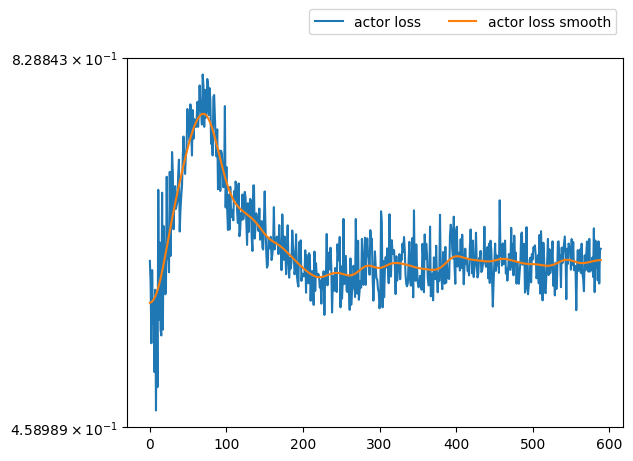

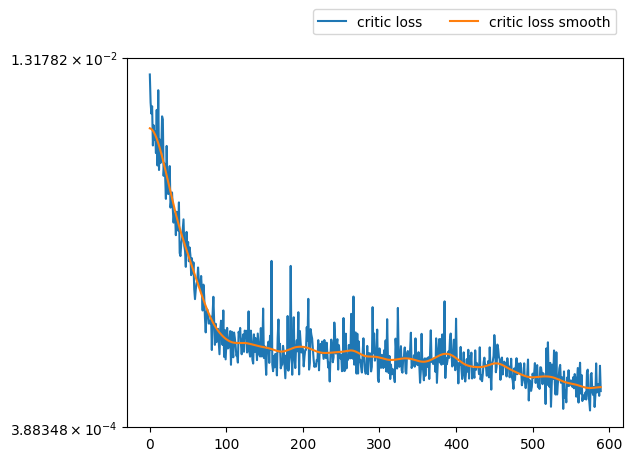

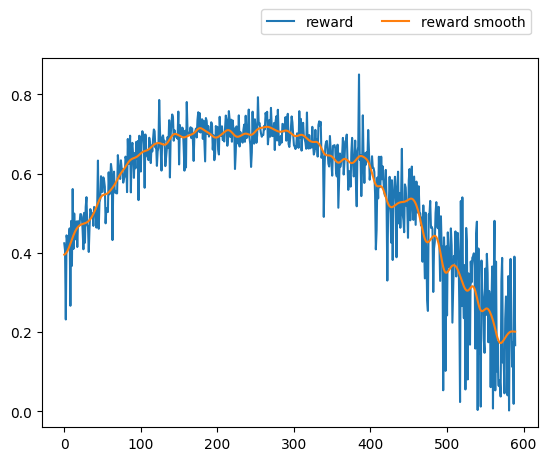

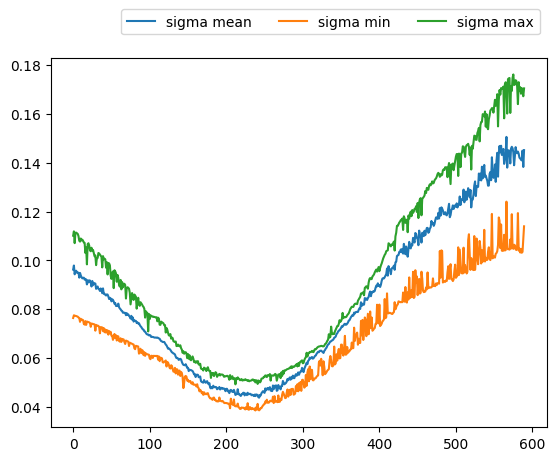

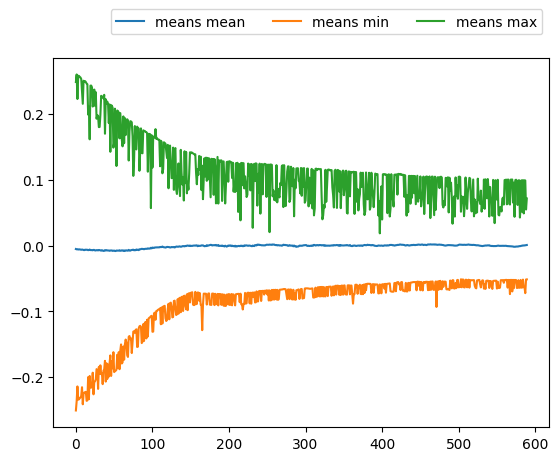

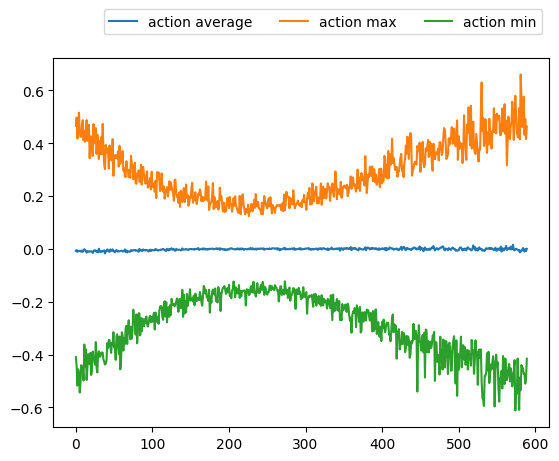

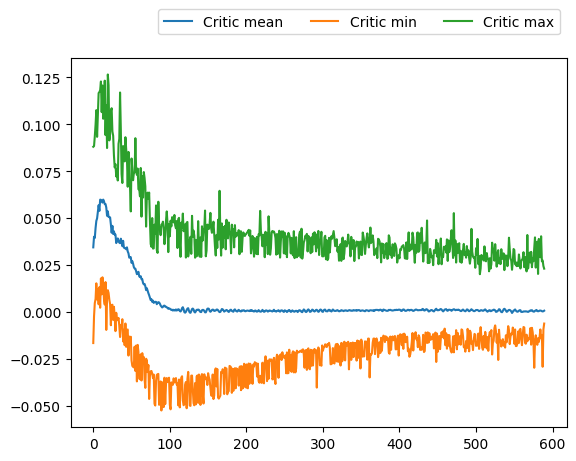

In [15]:
for i in range(NUM_OF_CYCLES):
    clear_output(wait=True)
    #print(f'Cylce: {i}')
    if training_cycle(i, NUM_OF_CYCLES):
        break
    plt.close('all')

%matplotlib inline

reward_log = reward_log
loss_history_actor = model.loss_actor_log.losses
loss_history_critic = model.loss_critic_log.losses
critic_mean = model.critic_mean_log
critic_var = model.critic_var_log
critic_min = model.critic_min_log
critic_max = model.critic_max_log
sigma_mean = model.sigma_mean_log
sigma_min = model.sigma_min_log
sigma_max = model.sigma_max_log
means_mean = model.means_mean_log
means_min = model.means_min_log
means_max = model.means_max_log

#plot rewards and losses
reward_log_smooth = gaussian_filter1d(reward_log, sigma=5)
loss_history_actor_smooth = gaussian_filter1d(model.loss_actor_log.losses, sigma=10)
loss_history_critic_smooth = gaussian_filter1d(model.loss_critic_log.losses, sigma=10)
#critic_mean = gaussian_filter1d(model.critic_mean_log, sigma=2)
#critic_var = gaussian_filter1d(model.critic_var_log, sigma=2)
#critic_min = gaussian_filter1d(model.critic_min_log, sigma=2)
#critic_max = gaussian_filter1d(model.critic_max_log, sigma=2)

#print(f'\nInitial weights:\n{inital_weights}')
#print(f'\n\nWeights in the end:\n{end_weights}\n')

plot_graph([loss_history_actor, loss_history_actor_smooth], ['actor loss', 'actor loss smooth'], scale='symlog')
plot_graph([loss_history_critic, loss_history_critic_smooth], ['critic loss', 'critic loss smooth'], scale='symlog')
plot_graph([reward_log, reward_log_smooth], ['reward', 'reward smooth'])
plot_graph([sigma_mean, sigma_min, sigma_max], ['sigma mean', 'sigma min', 'sigma max'])
plot_graph([means_mean, means_min, means_max], ['means mean', 'means min', 'means max'])
plot_graph([model.action_mean_log, model.action_max_log, model.action_min_log], ['action average', 'action max', 'action min'])
plot_graph([critic_mean, critic_min, critic_max], ['Critic mean', 'Critic min', 'Critic max'])